In [2]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import optimize

In [3]:
# Load dataset
exp_name = 'convective_coupling/land/all_lat_strip/evap'
ds = isca_tools.load_dataset(exp_name)
ds_season = isca_tools.load_dataset(exp_name+'/seasonal')
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau = namelist['two_stream_gray_rad_nml']['atm_abs']
namelist_file_name = os.path.join(namelist['experiment_details']['input_dir'], 'namelist.nml')

# Want only ocean coordinates.
# Because land is a strip covering all latitudes, we can get ocean dataset by only including ocean longitudes
ocean_lat, ocean_lon = isca_tools.utils.land.get_ocean_coords(namelist_file_name)
ds = ds.sel(lon=np.unique(ocean_lon), method='nearest')
ds_season = ds_season.sel(lon=np.unique(ocean_lon), method='nearest')

## Spin up
The net flux converges towards zero if the [actual surface pressure](https://jduffield65.github.io/Isca/namelists/main/spectral_dynamics/#ps) is used to [compute](https://jduffield65.github.io/Isca/code/utils/radiation/#isca_tools.utils.radiation.frierson_net_toa_sw_dwn) the net shortwave radiation at the top of the atmosphere.

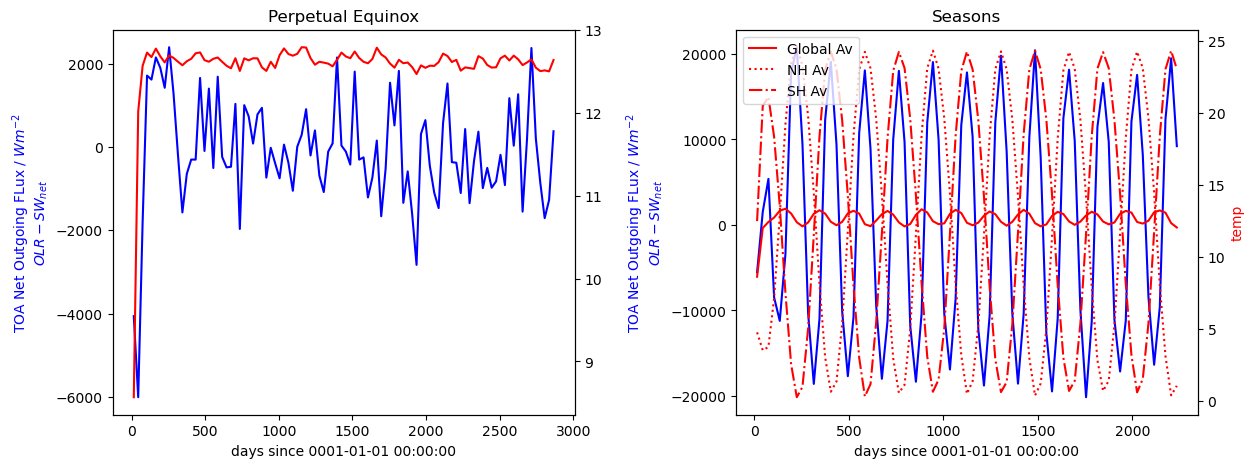

In [4]:
# Plot spin up time
fig, axs = plt.subplots(1,2, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds.olr, frierson_net_toa_sw_dwn(ds.swdn_toa, ds.ps, albedo, tau),
                             ds.temp.sel(pfull=2e5, method='nearest'), axs[0])
plt.title('')
plt.ylabel('')
isca_tools.plot.plot_spin_up(ds_season.olr, frierson_net_toa_sw_dwn(ds_season.swdn_toa, ds_season.ps, albedo, tau),
                             ds_season.temp.sel(pfull=2e5, method='nearest'), axs[1])
(isca_tools.utils.area_weighting(ds_season.temp.sel(pfull=2e5, method='nearest').sel(lat=slice(0,90))).mean(
    dim=['lon', 'lat'])- 273.15).plot(color='r', linestyle=':')
(isca_tools.utils.area_weighting(ds_season.temp.sel(pfull=2e5, method='nearest').sel(lat=slice(-90,0))).mean(
    dim=['lon', 'lat'])- 273.15).plot(color='r', linestyle='-.')
plt.legend(['Global Av','NH Av', 'SH Av'])
plt.title('')
axs[0].set_title('Perpetual Equinox')
axs[1].set_title('Seasons')
plt.subplots_adjust(wspace=0.35)

## Moist static energy
Want to see whether moist static energy is conserved i.e. same at surface and in free troposphere for each latitude.

In [5]:
# Take time and zonal mean
# Use all data after 3 years, as clearly converged from the above spin up plot
use_time_start = 360*3

# Perpetual Equinox near surface MSE and Free troposphere saturated MSE
ds_use = ds.sel(time=slice(use_time_start, np.inf)).mean(dim=['lon', 'time'])
mse_surface = moist_static_energy(ds_use.temp[-1], ds_use.sphum[-1], ds_use.height[-1])

pressure_ft = 700
ds_ft = ds_use.sel(pfull=pressure_ft, method='nearest')
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_ft.temp), ds_ft.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_ft_sat = moist_static_energy(ds_ft.temp, sphum_sat, ds_ft.height)

# Northern hemisphere summer near surface MSE and Free troposphere saturated MSE
ds_use_summer = ds_season.sel(time=slice(use_time_start, np.inf)).mean(dim=['lon'])
ds_use_summer = isca_tools.utils.annual_time_slice(ds_use_summer, [6, 7, 8]).mean(dim=['time'])    # NH summer is JJA
mse_surface_summer = moist_static_energy(ds_use_summer.temp[-1], ds_use_summer.sphum[-1], ds_use_summer.height[-1])

ds_ft_summer = ds_use_summer.sel(pfull=pressure_ft, method='nearest')
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_ft_summer.temp), ds_ft_summer.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_ft_sat_summer = moist_static_energy(ds_ft_summer.temp, sphum_sat, ds_ft_summer.height)

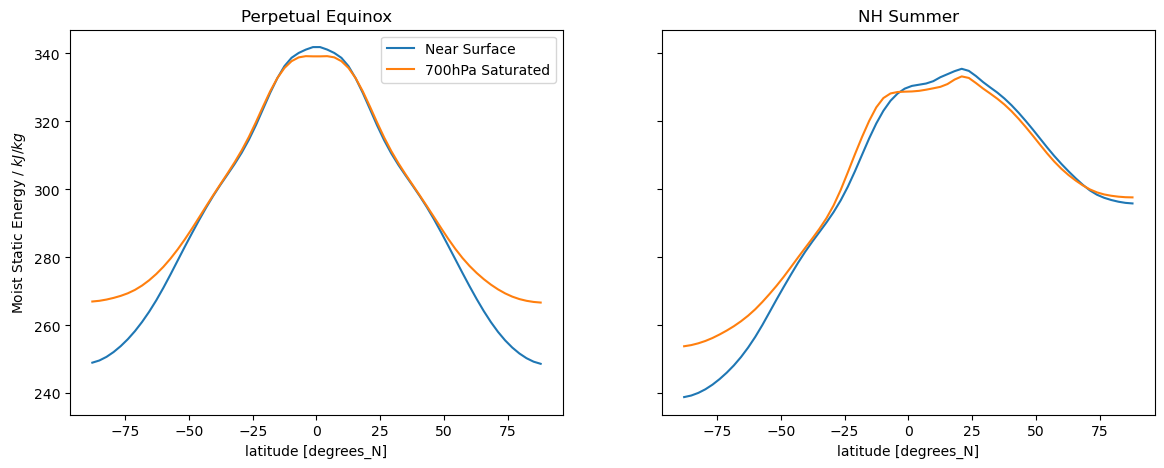

In [6]:
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
mse_surface.plot.line(ax=axs[0], add_legend=False, label="Near Surface")
mse_ft_sat.plot.line(ax=axs[0], add_legend=False, label=f"{pressure_ft}hPa Saturated")
axs[0].legend();
axs[0].set_ylabel('Moist Static Energy / $kJ/kg$');
axs[0].set_title('Time and Zonal mean Moist Static Energy distribution');

mse_surface_summer.plot.line(ax=axs[1], add_legend=False, label="Near Surface")
mse_ft_sat_summer.plot.line(ax=axs[1], add_legend=False, label=f"{pressure_ft}hPa Saturated")
axs[0].set_title('Perpetual Equinox')
axs[1].set_title('NH Summer');

In [7]:
# Consider each latitude and pressure value and compute difference between surface MSE and saturation MSE
# Perpetual Equinox
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use.temp), ds_use.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_all_sat = moist_static_energy(ds_use.temp, sphum_sat, ds_use.height)
mse_all_sat.name = 'saturation moist static energy';

mse_diff = (mse_surface-mse_all_sat)/mse_surface
mse_diff.name = '(Surface MSE - Saturation MSE)/Surface MSE'

# Northern Hemisphere Summer
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use_summer.temp), ds_use_summer.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_all_sat = moist_static_energy(ds_use_summer.temp, sphum_sat, ds_use_summer.height)
mse_all_sat.name = 'saturation moist static energy';

mse_diff_summer = (mse_surface_summer-mse_all_sat)/mse_surface_summer
mse_diff_summer.name = '(Surface MSE - Saturation MSE)/Surface MSE'

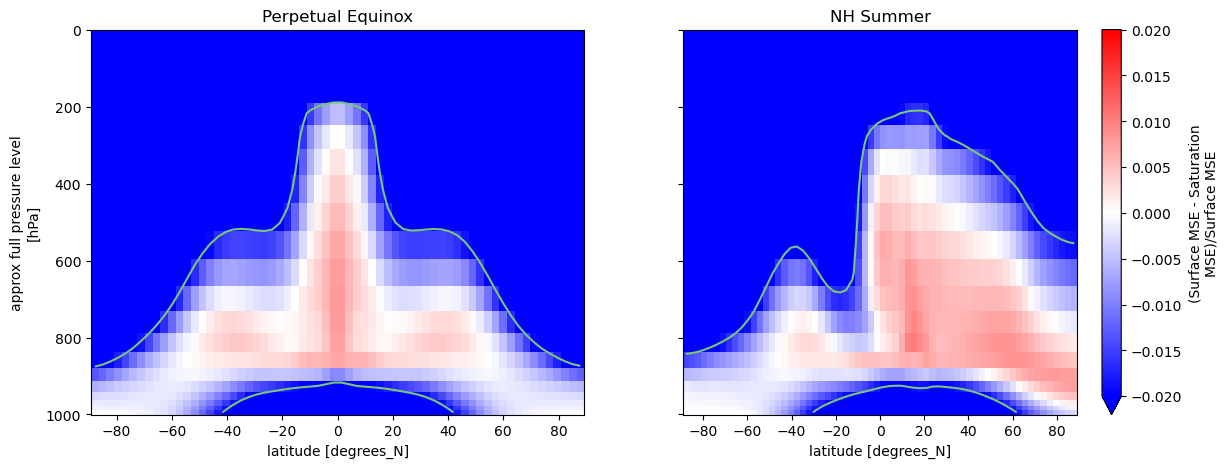

In [8]:
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
mse_diff.plot.pcolormesh(ax=axs[0], yincrease=False, vmin=-0.02, vmax=0.02, cmap='bwr', x='lat', add_colorbar=False)
mse_diff_summer.plot.pcolormesh(ax=axs[1], yincrease=False, vmin=-0.02, vmax=0.02, cmap='bwr', x='lat')
# Show contour where the dofference falls below 2%
axs[0].contour(mse_diff.lat.to_numpy(), mse_diff.pfull.to_numpy(), mse_diff.to_numpy().transpose(), [-0.02, 0.02],
               cmap='YlGn', vmin=-0.04, vmax=0)
axs[1].contour(mse_diff_summer.lat.to_numpy(), mse_diff_summer.pfull.to_numpy(), mse_diff_summer.to_numpy().transpose(), [-0.02, 0.02],
               cmap='YlGn', vmin=-0.04, vmax=0)
axs[1].set_ylabel('')
axs[0].set_title('Perpetual Equinox')
axs[1].set_title('NH Summer');

In [9]:
# Plot temperature profiles for tropics and extratropics.
# Compare them to convectively neutral profiles

# Perpetual Equinox
ds_tropics = ds_use.sel(lat=slice(-10,10)).mean(dim='lat')
tropics_temp_profile = convection_neutral_profile(float(ds_tropics.temp[-1]), float(ds_tropics.sphum.pfull[-1])*100,
                                                  float(ds_tropics.sphum[-1]), ds_tropics.temp.pfull.to_numpy()*100)

# For extratropics, average between 40-60 degrees latitude, use northern hemisphere
ds_extrop = ds_use.sel(lat=slice(40,60))
ds_extrop = area_weight_mean_lat(ds_extrop)
extrop_temp_profile = convection_neutral_profile(float(ds_extrop.temp[-1]), float(ds_extrop.sphum.pfull[-1])*100,
                                                 float(ds_extrop.sphum[-1]), ds_extrop.temp.pfull.to_numpy()*100)

# Seasons
ds_tropics_summer = ds_use_summer.sel(lat=slice(-10,10)).mean(dim='lat')
tropics_temp_profile_summer = convection_neutral_profile(float(ds_tropics_summer.temp[-1]), float(ds_tropics_summer.sphum.pfull[-1])*100,
                                                         float(ds_tropics_summer.sphum[-1]), ds_tropics_summer.temp.pfull.to_numpy()*100)

ds_extrop_summer = ds_use_summer.sel(lat=slice(40,60))
ds_extrop_summer = area_weight_mean_lat(ds_extrop_summer)
extrop_temp_profile_summer = convection_neutral_profile(float(ds_extrop_summer.temp[-1]), float(ds_extrop_summer.sphum.pfull[-1])*100,
                                                 float(ds_extrop_summer.sphum[-1]), ds_extrop_summer.temp.pfull.to_numpy()*100)

Variables Averaged: ['height', 'temp', 'sphum', 'ps', 'olr', 'swdn_toa']
Variables Averaged: ['height', 'temp', 'sphum', 'ps', 'olr', 'swdn_toa']


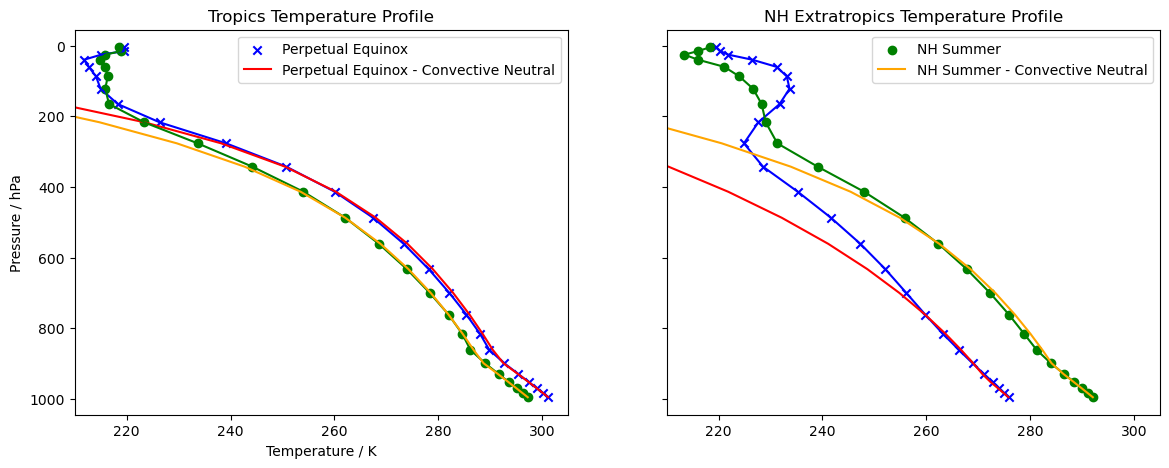

In [10]:
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
axs[0].plot(ds_tropics.temp.to_numpy(), ds_tropics.temp.pfull.to_numpy(), color='b')
axs[0].scatter(ds_tropics.temp.to_numpy(), ds_tropics.temp.pfull.to_numpy(), label='Perpetual Equinox', color='b', marker='x')
axs[0].plot(tropics_temp_profile, ds_tropics.temp.pfull.to_numpy(), label='Perpetual Equinox - Convective Neutral', color='r')

axs[0].plot(ds_tropics_summer.temp.to_numpy(), ds_tropics.temp.pfull.to_numpy(), color='g')
axs[0].scatter(ds_tropics_summer.temp.to_numpy(), ds_tropics_summer.temp.pfull.to_numpy(), color='g', marker='o')
axs[0].plot(tropics_temp_profile_summer, ds_tropics_summer.temp.pfull.to_numpy(), color='orange')

axs[1].plot(ds_extrop.temp.to_numpy(), ds_extrop.temp.pfull.to_numpy(), color='b')
axs[1].scatter(ds_extrop.temp, ds_extrop.temp.pfull.to_numpy(), color='b', marker='x')
axs[1].plot(extrop_temp_profile, ds_extrop.temp.pfull.to_numpy(), color='r')

axs[1].plot(ds_extrop_summer.temp.to_numpy(), ds_extrop_summer.temp.pfull.to_numpy(), color='g')
axs[1].scatter(ds_extrop_summer.temp, ds_extrop_summer.temp.pfull.to_numpy(), label='NH Summer', color='g', marker='o')
axs[1].plot(extrop_temp_profile_summer, ds_extrop_summer.temp.pfull.to_numpy(), label='NH Summer - Convective Neutral', color='orange')

axs[0].invert_yaxis()
axs[0].set_xlim([210, 305])
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel('Temperature / K')
axs[0].set_ylabel('Pressure / hPa')
axs[0].set_title('Tropics Temperature Profile')
axs[1].set_title('NH Extratropics Temperature Profile');

## Comparison to 5m Depth
This is exactly the same as the [5m depth results](https://github.com/jduffield65/Isca/blob/main/jobs/convective_coupling/aquaplanet/d5_sphum/mse_notebook.ipynb), as expected because the options used are identical for the ocean coordinates.
